##Preamble

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/python/BayesianFiltering

/content/drive/MyDrive/python/BayesianFiltering


In [ ]:
from ssm import StateSpaceModel
from ssm import LinearModelParameters
from SLDS import SLDS
from simulation import Simulation
from ssm import LGSSM
import numpy as np
import copy
import matplotlib.pyplot as plt

## Testing

[]

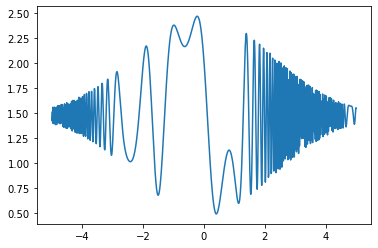

In [ ]:
dx = 1
dy = 1
T = 200
alpha = 1
params = LinearModelParameters(0, 0, 0, np.eye(dx), 0.1*np.eye(dy))

g = lambda x: x + np.random.normal(np.zeros(dy), params.R)
jacob_obs = lambda x: 1
sigma = lambda x: 1 / (1 + np.exp(-alpha*x))
a = 2
poly = lambda x: -x**4 - 3*x**3 + 2*x**2 + 5*x -10
f = lambda x: np.sin(poly(x))*np.exp(-x**2/10) + np.random.normal(np.zeros(dx), params.Q)

ssm = StateSpaceModel(dx, dy, params, f, g)
simul = ssm.simulate(T, 100)

fig3, axes3 = plt.subplots(1,1)
xx = np.linspace(- 5, 5, 1000)
#axes3.plot(xx, poly(xx))
axes3.plot(xx, np.squeeze(f(xx)))

#plt.plot(simul[0])
plt.plot()

In [ ]:
dx = 2
dy = 2
T = 100
params = LinearModelParameters(0, 0, 0, np.eye(dx), np.eye(dy))
g = lambda x: x + np.random.multivariate_normal(np.zeros(dy), params.R)
jacob_obs = lambda x: 1
sigma = lambda x: 1 / (1 + np.exp(-x))
A = np.array([[1,0.5 ],[-0.5, 1]])
f = lambda x: np.array(list(map(sigma, np.matmul(A, x)))) + np.random.multivariate_normal(np.zeros(dx), params.Q)
exp_a = lambda a,x : np.exp(-np.dot(a,x)) / ( 1 + np.exp(-np.dot(a,x)) )**2
jacob_dyn = lambda x:  np.matmul(np.array([[exp_a(A[0], x), 0],[0 , exp_a(A[1], x)]]),A)
print(jacob_dyn(np.array([1,1])))

ssm = StateSpaceModel(dx, dy, params, f, g)
simul = ssm.simulate(T, np.zeros(dx))
plt.scatter(simul[0][:,0],simul[0][:,1])
plt.plot()

[[ 0.14914645  0.07457323]
 [-0.11750186  0.23500371]]


ValueError: ignored

In [ ]:
T = 100
Nsim = 10

dx = 1
dy = 1

## 1-D
params = LinearModelParameters(0, 0, 0, 1, 1)
g = lambda x: x + np.random.normal(0, params.R)
jacob_obs = lambda x: np.eye(dy)
rate = 0.8
poly = lambda x: -x**4 - 3*x**3 + 2*x**2 + 5*x -10
f = lambda x: np.sin(poly(x))*np.exp(-x**2/rate) + np.random.normal(np.zeros(dx), params.Q)
jacob_dyn = lambda x: -(2*x/rate) * np.sin(poly(x))*np.exp(-x**2/rate) + \
                          np.cos(poly(x))*np.exp(-x**2/rate) * \
                          (-4*x**3 - 9*x**2 + 4*x + 5)


## n-D
# params = LinearModelParameters(np.eye(dx), np.zeros([1,dx]), np.eye(dy,dx), np.eye(dx), np.eye(dy))
# g = lambda x: np.matmul(x, params.H.T) + np.random.multivariate_normal(np.zeros(dy), np.eye(dy))
# jacob_obs = lambda x: params.H


num_param_vals = 1
num_comp = 40
latent_cov = 0.0001
init = [np.zeros(dx), np.eye(dx)]
error = np.zeros(Nsim)
error_latent = np.zeros(Nsim)
error_UKF = np.zeros(Nsim)
mean_error = np.zeros(num_param_vals)
mean_error_lat = np.zeros(num_param_vals)
mean_error_UKF = np.zeros(num_param_vals)
freq = 10
i = 0
count = 0
for param_idx in range(0, num_param_vals):
    #latent_cov =  np.eye(dx) / (2.0 + param_idx * 10)
    ## 1-D
    #f = lambda x:  np.sin(x) * np.sin(freq * x) + np.random.normal(0, params.Q)
    #jacob_dyn = lambda x:  np.sin(x) * freq * np.cos(freq * x) + np.cos(x) * np.sin(freq * x)


    ## 2-D
    # Lotka-Voltera
    # (a,b,c,d) = (2/3, 4/3, 1, 1)
    # f = lambda x: 0.1 * np.matmul(np.array([[1-a, -b*x[0]], [d*x[1], 1 - c]]), x) + np.random.multivariate_normal(np.zeros(2), params.Q)
    # jacob_dyn = lambda x: 0.1 * np.array([[1-b*x[1], -b*x[0]], [d*x[1], d*x[0] - c]])
    # A = np.array([[1,0.5 ],[-0.5, 1]])
    # f = lambda x: np.array(list(map(sigma, np.matmul(A, x)))) + np.random.multivariate_normal(np.zeros(dx), params.Q)
    # exp_a = lambda a,x : np.exp(-np.dot(a,x)) / ( 1 + np.exp(-np.dot(a,x)) )**2
    # jacob_dyn = lambda x:  np.matmul(np.array([[exp_a(A[0], x), 0],[0 , exp_a(A[1], x)]]),A)
    ssm = StateSpaceModel(dx, dy, params, f, g)
    for run in range(Nsim):
        simul = ssm.simulate(T, np.zeros(dx))
        means, covs = ssm.extended_kalman_filter(simul[1], jacob_dyn, jacob_obs, params, init)
        means_latent, covs_latent = ssm.latent_ekf(simul[1], num_comp, latent_cov, jacob_dyn, jacob_obs, params, init)
        means_UKF, covs_UKF = ssm.unscented_kalman_filter(simul[1], init, params, 10, 2, 1) # alpha = 1 / np.sqrt(dx)
        error[run] = np.linalg.norm(means[1:] - simul[0][:T-1])
        error_latent[run] = np.linalg.norm(means_latent[1:] - simul[0][:T-1])
        error_UKF[run] = np.linalg.norm(means_UKF[1:] - simul[0][:T - 1])
        print(count)
        count += 1
    mean_error[i] = np.mean(error)
    mean_error_lat[i] = np.mean(error_latent)
    mean_error_UKF[i] = np.mean(error_UKF)
    i += 1

print('Error EKF:', mean_error)
print('Error LEKF:', mean_error_lat)
print('Error UKF:', mean_error_UKF)



0
1
2
3
4
5
6
7
8
9
Error EKF: [12.59735736]
Error LEKF: [9.81330661]
Error UKF: [18.97608369]


## Experiment

Error EKF: [8.1022387  7.60050689 7.54286094 7.79077214 7.81042924 8.09320936
 8.00177965 7.74330014 7.67478875 7.43009565 7.95363169 7.67041173
 7.90460697 7.88862359 7.77652346 7.6865686  7.80175859 7.97576781
 8.35039233 7.64848778 7.63588298 7.82508267 8.00185711 7.97669738
 7.79061045 8.01445145 7.73696638 7.85257502 8.07812525]
Error LEKF: [7.84901271 7.23847559 7.08416648 7.42322197 7.39866021 7.41011759
 7.58996132 7.25351136 7.21266868 7.02825696 7.55395035 7.19094554
 7.30840251 7.23400787 7.26978867 7.21031909 7.51085669 7.42103971
 7.76497521 7.25927769 7.26232214 7.24429425 7.43125006 7.30468676
 7.34538415 7.380327   7.25815935 7.3868989  7.45087985]
Error UKF: [13.95722473 13.87101203 13.97537715 13.8384715  14.09071348 14.04440038
 13.67563751 14.30716984 13.78601419 13.45126716 14.1091071  13.66217783
 13.25784927 13.80468756 13.97189138 13.60831147 14.04963553 13.86969256
 13.92046946 14.19962972 14.16426524 13.79979816 14.448111   13.72770194
 13.96706953 13.92081136

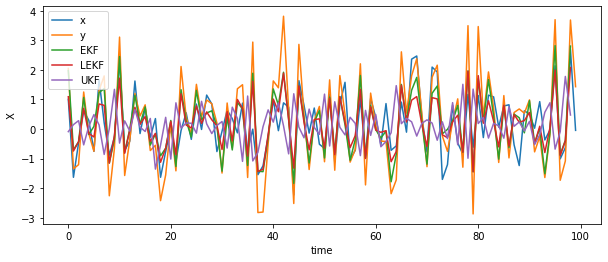

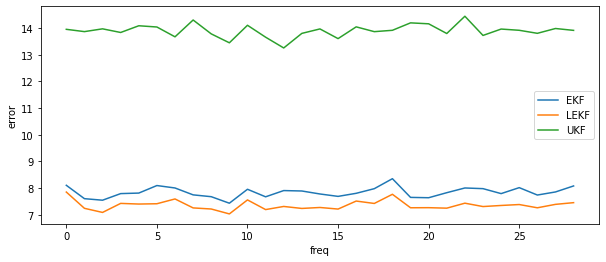

In [ ]:
T = 100
Nsim = 10

dx = 1
dy = 1

## 1-D
params = LinearModelParameters(0, 0, 0, 1, 1)
g = lambda x: x 
jacob_obs = lambda x: 1
rate = 0.8
poly = lambda x: -x**4 - 3*x**3 + 2*x**2 + 5*x -10
f = lambda x: np.sin(poly(x))*np.exp(-x**2/rate) 
jacob_dyn = lambda x: -(2*x/rate) * np.sin(poly(x))*np.exp(-x**2/rate) + \
                          np.cos(poly(x))*np.exp(-x**2/rate) * \
                          (-4*x**3 - 9*x**2 + 4*x + 5)


ssm = StateSpaceModel(dx, dy, params, f, g)

latent_cov =  0.01
max_num_comp = 30
num_param_vals = 10
num_comp = 10
init = [np.zeros(dx), np.eye(dx)]
error = np.zeros(Nsim)
error_latent = np.zeros(Nsim)
error_UKF = np.zeros(Nsim)
mean_error = np.zeros(max_num_comp-1)
mean_error_lat = np.zeros(max_num_comp-1)
mean_error_UKF = np.zeros(max_num_comp-1)
i = 0
count = 0
for num_comp in range(1, max_num_comp): 
    for run in range(Nsim):
        simul = ssm.simulate(T, np.zeros(dx))
        means, covs = ssm.extended_kalman_filter(simul[1], jacob_dyn, jacob_obs, params, init)
        means_latent, covs_latent = ssm.latent_ekf(simul[1], num_comp, latent_cov, jacob_dyn, jacob_obs, params, init)
        means_UKF, covs_UKF = ssm.unscented_kalman_filter(simul[1], init, params, 10, 2, 1) # alpha = 1 / np.sqrt(dx)
        error[run] = np.linalg.norm(means[1:] - simul[0][:T-1])
        error_latent[run] = np.linalg.norm(means_latent[1:] - simul[0][:T-1])
        error_UKF[run] = np.linalg.norm(means_UKF[1:] - simul[0][:T - 1])
        count += 1
    mean_error[i] = np.mean(error)
    mean_error_lat[i] = np.mean(error_latent)
    mean_error_UKF[i] = np.mean(error_UKF)
    i += 1

print('Error EKF:', mean_error)
print('Error LEKF:', mean_error_lat)
print('Error UKF:', mean_error_UKF)


fig1, axes1 = plt.subplots(1, 1, sharex=True, figsize=(10, 4))
p1 = axes1.plot(simul[0])
p2 = axes1.plot(simul[1])
p3 = axes1.plot(means[1:])
p4 = axes1.plot(means_latent[1:])
p5 = axes1.plot(means_UKF[1:])
axes1.set_ylabel("X")
axes1.set_xlabel("time")
axes1.legend(['x', 'y', 'EKF', 'LEKF', 'UKF'])

fig2, axes2 = plt.subplots(1, 1, sharex=True, figsize=(10, 4))
p1 = axes2.plot(mean_error)
p2 = axes2.plot(mean_error_lat)
p3 = axes2.plot(mean_error_UKF)
axes2.set_ylabel("error")
axes2.set_xlabel("freq")
#axes2.set_title("Ex Cond VS Est")
axes2.legend(['EKF', 'LEKF', 'UKF'])

plt.show()